In [ ]:
%load_ext autoreload
%aimport gtools, FakeDataMaker
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import iqtools as iq
import matplotlib.pyplot as plt
from lmfit import Model
import gtools as gt
import FakeDataMaker as fm
import pandas as pd
%matplotlib inline

In [ ]:
# import data
rawdata = f'data/fumikara.TIQ'
iqdata = iq.get_iq_object(rawdata)

fm.print_info(iqdata)

centre frequency: 173.378 MHz
measurement time: 6.68043264 sec
sampling rate: 0.048828125 MHz
sample size: 326193


In [ ]:
# isotope data
filename = '79as.csv'
freq_dat, mom_dat, isotope_name = fm.import_data(filename, corrected=False)

In [ ]:
# set params & read data
lframes = int(2000)  # number of bins in freq.
freq_bin_size = iqdata.fs/lframes
t_bin_size = 1/freq_bin_size

# nframes = int(6.68/(t_bin_size))  # number of time bins
# sframes = int(0/t_bin_size)  # number of time bins to skip
nframes = int(iqdata.nsamples_total/lframes)
iqdata.read(nframes, lframes)


In [ ]:
# get power spectrum
iqdata.window = 'hamming'
iqdata.method = 'mtm'
xx, yy, zz = iqdata.get_power_spectrogram(nframes=nframes, lframes=lframes)

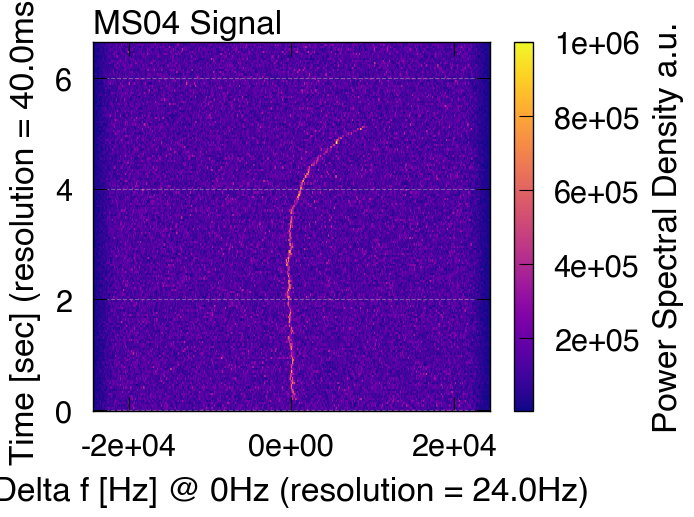

In [ ]:
iq.plot_spectrogram(xx, yy, zz,
                 title='MS04 Signal',
                 cmap='plasma',
                 decimal_place=0 # Too many digits for me
                 )

# plt.gcf().set_size_inches(8, 6)
# plt.savefig('plots/fumi-san_signal.pdf', bbox_inches='tight')


In [ ]:
xxcut, yycut, zzcut = iq.get_cut_spectrogram(xx, yy, zz, ycen=0, yspan=3.6*2)

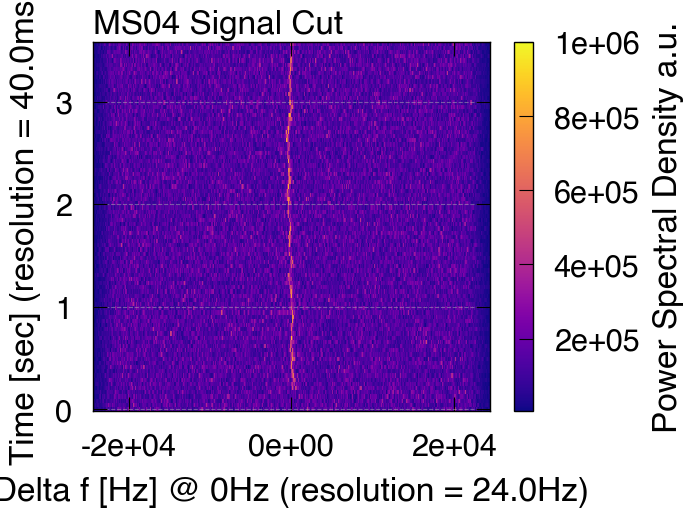

In [ ]:
iq.plot_spectrogram(xxcut, yycut, zzcut,
                 title='MS04 Signal Cut',
                 cmap='plasma',
                 decimal_place=0 # Too many digits for me
                 )

In [ ]:
# get averaged spectrogram
freq_avg, pwr_avg = gt.time_average(iqdata, xxcut, yycut, zzcut, 0, 60, dbm=False)
pwr_avg_dbm = iqdata.get_dbm(pwr_avg)

In [ ]:
signal_center, result1 = fm.get_fit_center(
    freq_avg,
    pwr_avg,
    amp=1e-5,
    cen=0,
    sigma=25,
    yoffset=0,
    result=True
)

In [ ]:
gmodel = Model(fm.gaussian)
gresult_single_signal_fit = gmodel.fit(
    pwr_avg,
    x=freq_avg,
    amp=4e-6,
    cen=freq_avg[np.argmax(pwr_avg)],
    sigma=500,
    yoffset=3e-6,
)
gresult_single_signal_fit

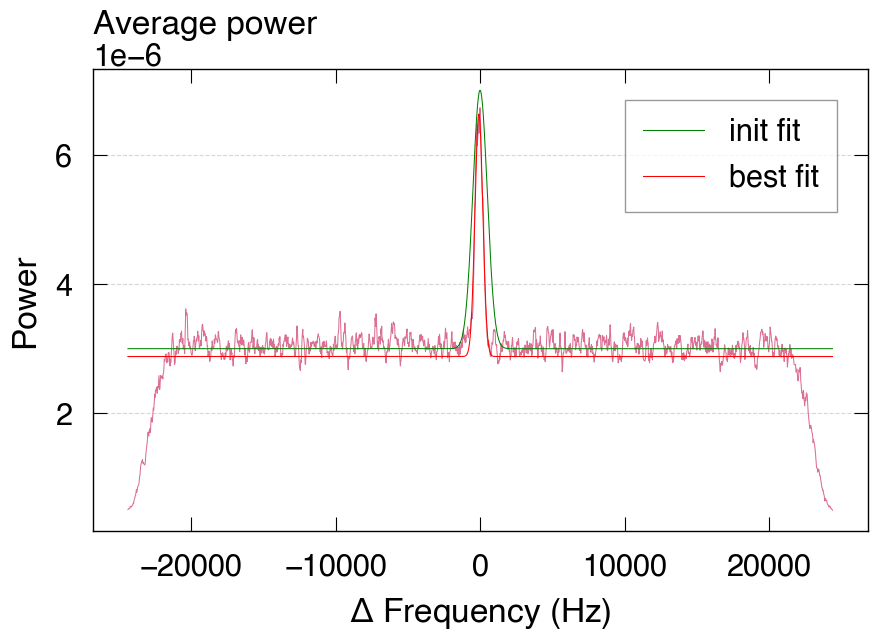

In [ ]:
# figure - average power spectrum
plt.style.use('/Users/gwgwhc/Documents/code/stylelib/ticksin_helvetica.mplstyle')
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(
    freq_avg, pwr_avg,
    color='palevioletred',
    linestyle='-',
    linewidth=0.75
)

ax.plot(
    freq_avg, gresult_single_signal_fit.init_fit,
    color='green',
    linewidth=0.75,
    label='init fit'
)

ax.plot(
    freq_avg, gresult_single_signal_fit.best_fit,
    color='red',
    linewidth=0.75,
    label='best fit'
)

# ax.vlines(freq_avg[np.argmax(pwr_avg)], 1e-6, 7e-6)

span1 = 5000
# ax.set_xlim(signal_center-span1, signal_center+span1)
# ax.set_ylim(-24, -14)

ax.set_title('Average power')
ax.set_xlabel('$\Delta$ Frequency (Hz)')
ax.set_ylabel('Power')

ax.legend()

plt.show()

In [ ]:
current_res = int(-(-(np.max(freq_avg) - np.min(freq_avg)) // len(freq_avg)))
current_res

25

In [ ]:
# interpolate data according to estimated resolution:
intp_factor = current_res
xnew = np.linspace(np.min(freq_avg), np.max(freq_avg), len(freq_avg)*intp_factor)
interp_signal = np.interp(xnew, freq_avg, pwr_avg)

In [ ]:
with open("data/interp_single_sig.csv", "w") as file:
    for x, y in zip(xnew, interp_signal):
        file.write(f"{x}, {y}\n")

In [ ]:
imported_interp_data = np.transpose(np.genfromtxt('data/interp_single_sig.csv', delimiter=','))

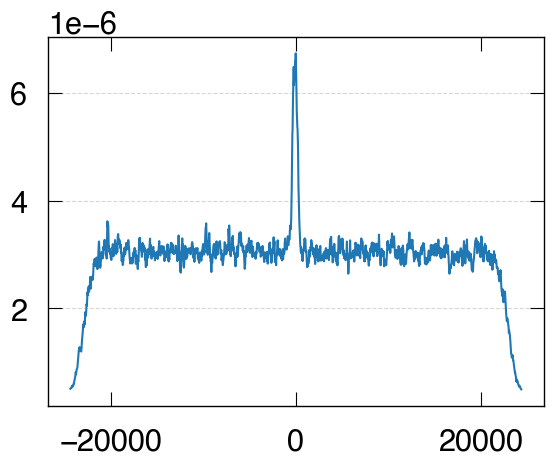

In [ ]:
plt.plot(imported_interp_data[0], imported_interp_data[1])

In [ ]:
# find zero index
zero_index = np.abs(xnew).argmin()
len_x = len(xnew)
zero_index

24999

In [ ]:
# create fake frequency data to overlay peaks on
canvas = np.linspace(np.mean(freq_dat)-len_x, np.mean(freq_dat)+len_x, len_x*4)

In [ ]:
total_power = fm.create_fake_data(canvas, freq_dat, interp_signal, signal_center)

In [ ]:
# fit params
span2 = int(1e4)
cen_bin = np.argmax(total_power)
cen2 = canvas[cen_bin]
cen_bin-int(span2)

114977

In [ ]:
# gaussian fit
gmodel = Model(fm.gaussian)
gresult = gmodel.fit(
    total_power[cen_bin-span2:cen_bin+span2],
    x=canvas[cen_bin-span2:cen_bin+span2],
    amp=4e-5,
    cen=canvas[np.argmax(total_power)],
    sigma=3e2,
    yoffset=4e-5
)

gresult.result

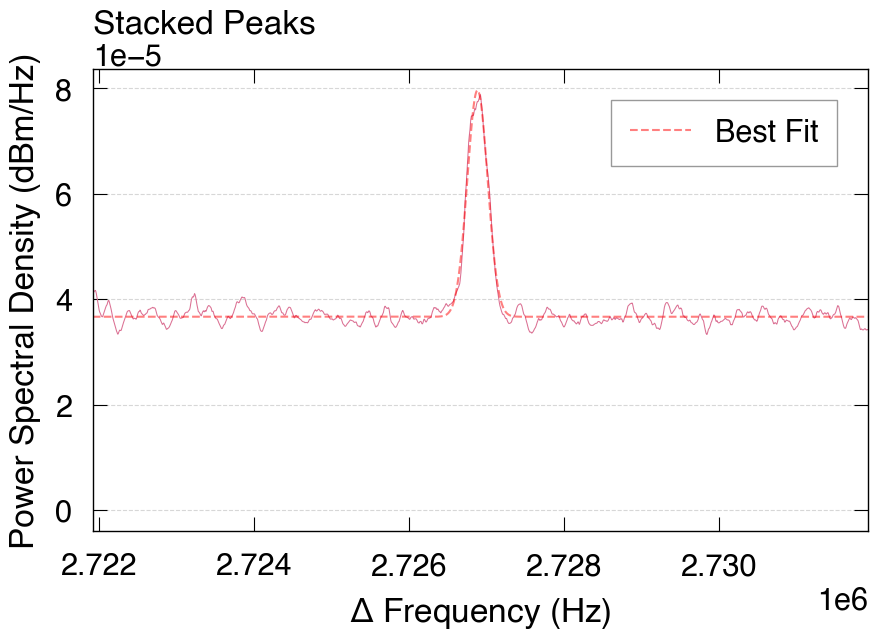

In [ ]:
# figure - stacked peaks
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# signal
ax.plot(
    # canvas, gt.get_dbm(total_power),
    canvas, total_power,
    color='palevioletred',
    linestyle='-',
    linewidth=0.75
)

# initial fit
# ax.plot(
#     canvas[cen_bin-span2:cen_bin+span2], gresult.init_fit,
#     color='green',
#     linestyle='--',
#     label='Init Fit',
# )

# best fit
ax.plot(
    canvas[cen_bin-span2:cen_bin+span2], gresult.best_fit,
    color='red',
    linestyle='--',
    label='Best Fit',
    alpha=0.5
)

# center line
# ax.vlines(cen2-5e2, 0, 8e-5)

ax.set_xlim(cen2-span2/2,cen2+span2/2)

ax.set_title('Stacked Peaks')
ax.set_xlabel('$\Delta$ Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dBm/Hz)')

ax.legend()

# plt.savefig('plots/stacked_peaks.pdf', bbox_inches='tight')

In [ ]:
# now make 2000 particles with distribution matching initial signal's distribution.
f_distribution= [np.random.normal(np.mean(freq_dat), gresult.params['sigma'].value) for i in range(2000)]
power_distribution = fm.create_fake_data(canvas, f_distribution, interp_signal, signal_center)


In [ ]:
gresult_distribution = gmodel.fit(
    power_distribution[cen_bin-span2:cen_bin +span2],
    x=canvas[cen_bin-span2:cen_bin+span2],
    amp=1e-2,
    cen=canvas[np.argmax(power_distribution)],
    sigma=3e2,
    yoffset=5e-3
)

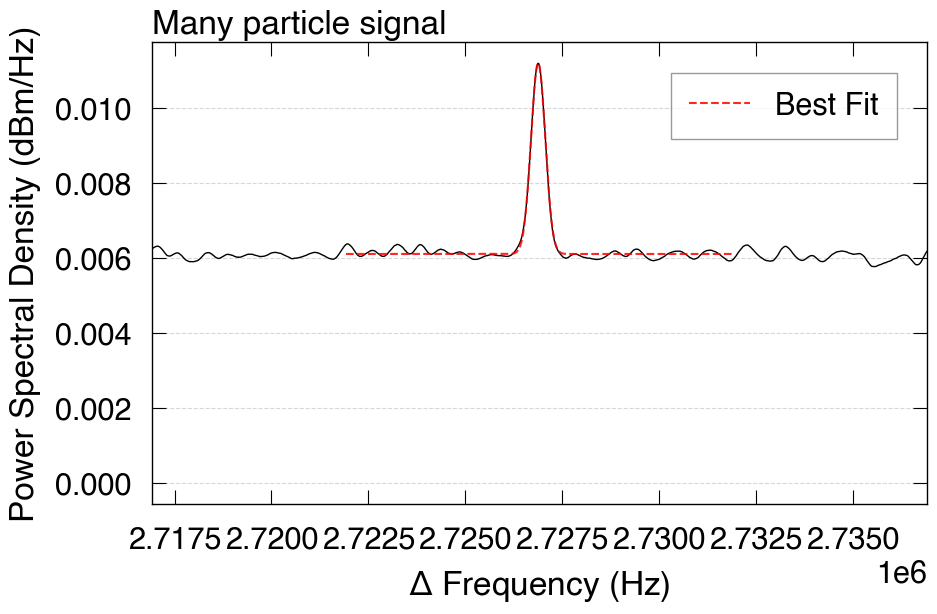

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(
    canvas, power_distribution,
    color='black',
    linestyle='-',
    linewidth=1
)

# ax.plot(
#     canvas[cen_bin-span2:cen_bin+span2], gresult_distribution.init_fit,
#     color='green',
#     linestyle='--',
#     label='Init Fit',
# )

ax.plot(
    canvas[cen_bin-span2:cen_bin+span2], gresult_distribution.best_fit,
    color='red',
    linestyle='--',
    alpha=0.85,
    label='Best Fit',
)

ax.set_xlim(cen2-span2,cen2+span2)
# ax.set_yscale('log')
# ax.vlines(cen2-5e2, 0, 8e-5)

ax.set_title('Many particle signal')
ax.set_xlabel('$\Delta$ Frequency (Hz)')
ax.set_ylabel('Power Spectral Density (dBm/Hz)')

ax.legend()

In [ ]:
gresult_distribution.result